# Image Super-Resolution using an Efficient Sub-Pixel CNN

**Author:** [Xingyu Long](https://github.com/xingyu-long)<br>
**Date created:** 2020/07/28<br>
**Last modified:** 2020/08/27<br>
**Description:** Implementing Super-Resolution using Efficient sub-pixel model on BSDS500.

## Introduction

ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi, 2016](https://arxiv.org/abs/1609.05158)
is a model that reconstructs a high-resolution version of an image given a low-resolution version.
It leverages efficient "sub-pixel convolution" layers, which learns an array of
image upscaling filters.

In this code example, we will implement the model from the paper and train it on a small dataset,
[BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).

## Setup

In [1]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

## Load data: BSDS500 dataset

### Download dataset

We use the built-in `keras.utils.get_file` utility to retrieve the dataset.

In [2]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = r"C:\Users\soggy\Videos\MRIImagesDataset\images"

We create training and validation datasets via `image_dataset_from_directory`.

In [3]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 942 files belonging to 1 classes.
Using 754 files for training.
Found 942 files belonging to 1 classes.
Using 188 files for validation.


In [4]:
root_dir

'C:\\Users\\soggy\\Videos\\MRIImagesDataset\\images'

We rescale the images to take values in the range [0, 1].

In [5]:

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Let's visualize a few sample images:

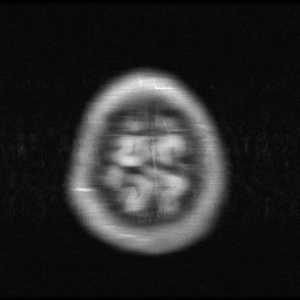

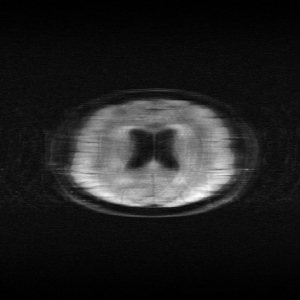

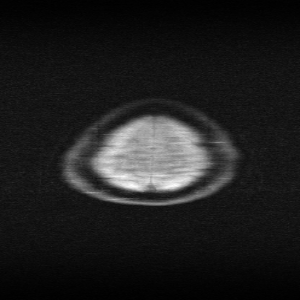

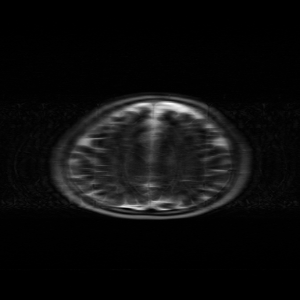

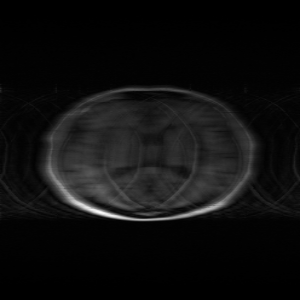

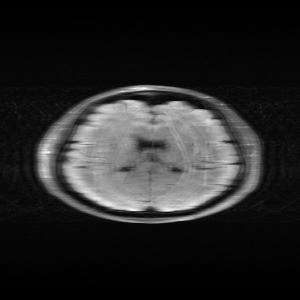

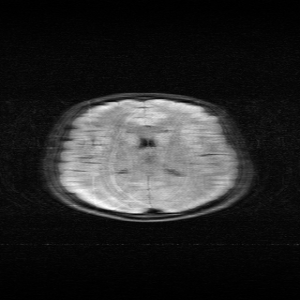

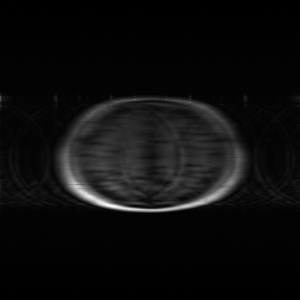

In [6]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

We prepare a dataset of test image paths that we will use for
visual evaluation at the end of this example.

In [8]:
dataset = root_dir
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)

## Crop and resize images

Let's process image data.
First, we convert our images from the RGB color space to the
[YUV colour space](https://en.wikipedia.org/wiki/YUV).

For the input data (low-resolution images),
we crop the image, retrieve the `y` channel (luninance),
and resize it with the `area` method (use `BICUBIC` if you use PIL).
We only consider the luminance channel
in the YUV color space because humans are more sensitive to
luminance change.

For the target data (high-resolution images), we just crop the image
and retrieve the `y` channel.

In [9]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Let's take a look at the input and target data.

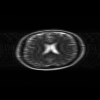

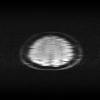

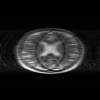

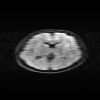

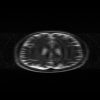

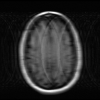

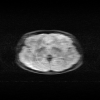

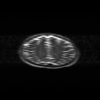

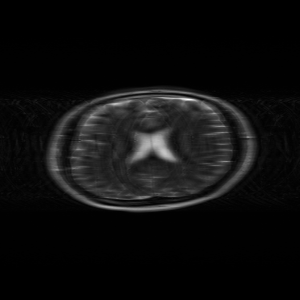

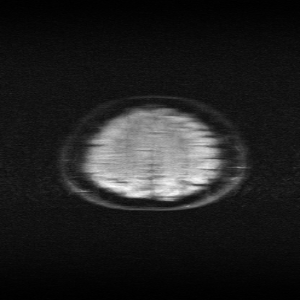

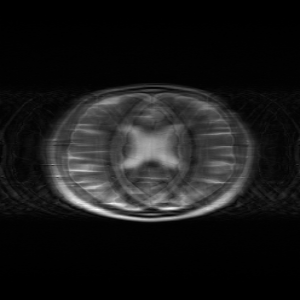

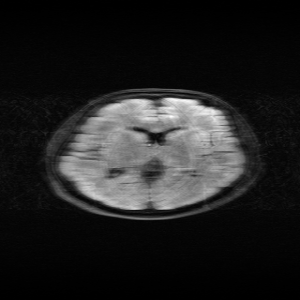

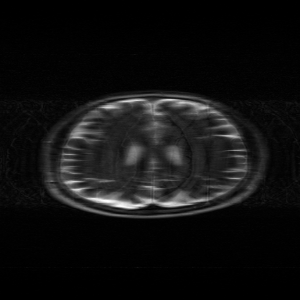

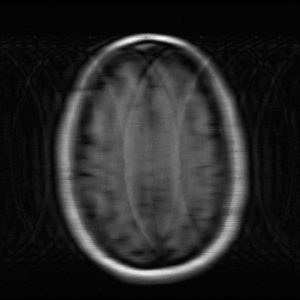

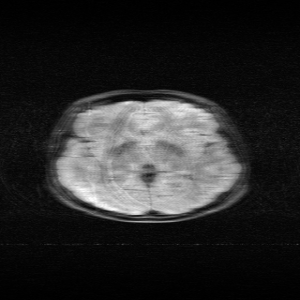

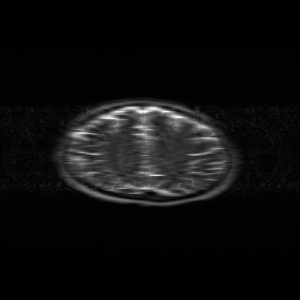

In [10]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

## Build a model

Compared to the paper, we add one more layer and we use the `relu` activation function
instead of `tanh`.
It achieves better performance even though we train the model for fewer epochs.

In [11]:

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display
the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric.
This is the main metric we use to evaluate super-resolution performance.

In [13]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


Define `ModelCheckpoint` and `EarlyStopping` callbacks.

In [14]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

## Train the model

Epoch 1/10
Mean PSNR for epoch: 33.20
1/1 [==============================] - 0s 89ms/step


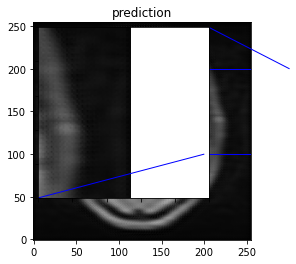

95/95 - 28s - loss: 0.0042 - val_loss: 4.6981e-04 - 28s/epoch - 299ms/step
Epoch 2/10
Mean PSNR for epoch: 35.17
95/95 - 32s - loss: 3.5581e-04 - val_loss: 3.0866e-04 - 32s/epoch - 335ms/step
Epoch 3/10
Mean PSNR for epoch: 35.15
95/95 - 30s - loss: 3.1042e-04 - val_loss: 3.0331e-04 - 30s/epoch - 320ms/step
Epoch 4/10
Mean PSNR for epoch: 35.62
95/95 - 32s - loss: 2.7430e-04 - val_loss: 2.6771e-04 - 32s/epoch - 337ms/step
Epoch 5/10
Mean PSNR for epoch: 36.06
95/95 - 35s - loss: 2.6051e-04 - val_loss: 2.5568e-04 - 35s/epoch - 365ms/step
Epoch 6/10
Mean PSNR for epoch: 35.86
95/95 - 32s - loss: 2.5520e-04 - val_loss: 2.5087e-04 - 32s/epoch - 337ms/step
Epoch 7/10
Mean PSNR for epoch: 36.21
95/95 - 32s - loss: 2.6738e-04 - val_loss: 2.4555e-04 - 32s/epoch - 339ms/step
Epoch 8/10
Mean PSNR for epoch: 36.17
95/95 - 31s - loss: 2.4291e-04 - val_loss: 2.4165e-04 - 31s/epoch - 330ms/step
Epoch 9/10
Mean PSNR for epoch: 36.13
95/95 - 28s - loss: 2.3833e-04 - val_loss: 2.4057e-04 - 28s/epoch - 

In [15]:
epochs = 10

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

## Run model prediction and plot the results

Let's compute the reconstructed version of a few images and save the results.

1/1 [==============================] - 0s 62ms/step
PSNR of low resolution image and high resolution image is 41.2908
PSNR of predict and high resolution is 41.2646


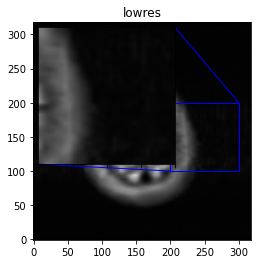

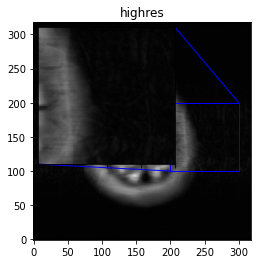

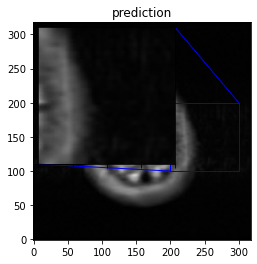

1/1 [==============================] - 0s 20ms/step
PSNR of low resolution image and high resolution image is 42.9223
PSNR of predict and high resolution is 42.6746


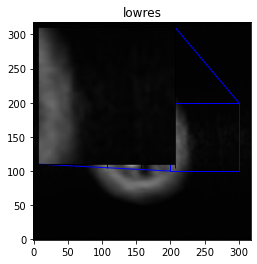

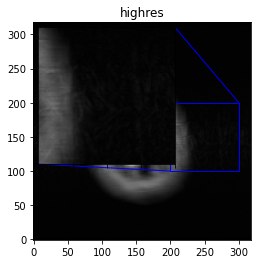

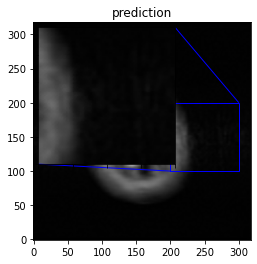

1/1 [==============================] - 0s 20ms/step
PSNR of low resolution image and high resolution image is 42.1187
PSNR of predict and high resolution is 41.8248


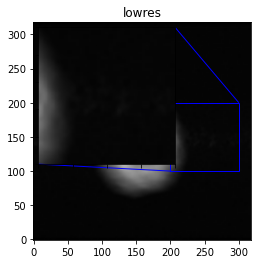

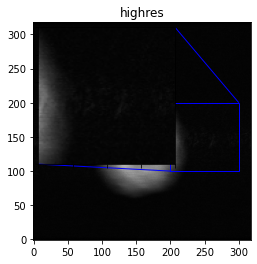

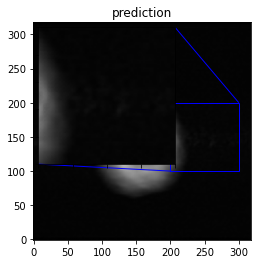

1/1 [==============================] - 0s 21ms/step
PSNR of low resolution image and high resolution image is 41.8725
PSNR of predict and high resolution is 41.6258


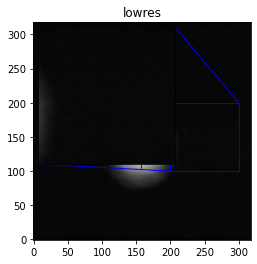

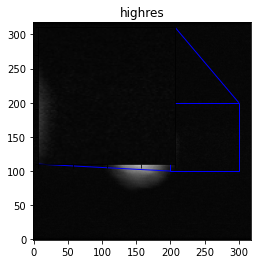

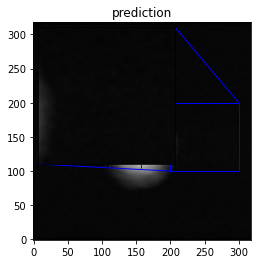

1/1 [==============================] - 0s 19ms/step
PSNR of low resolution image and high resolution image is 37.7096
PSNR of predict and high resolution is 37.4424


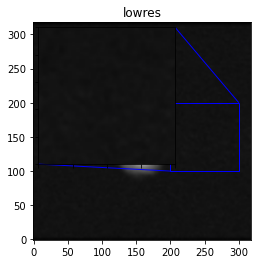

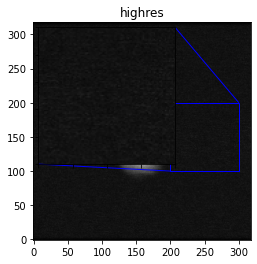

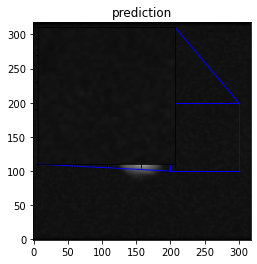

1/1 [==============================] - 0s 21ms/step
PSNR of low resolution image and high resolution image is 35.4382
PSNR of predict and high resolution is 36.5500


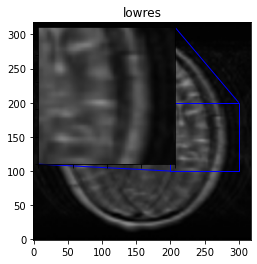

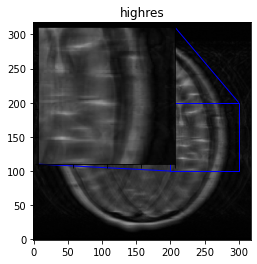

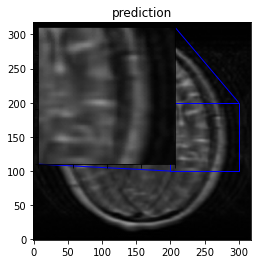

1/1 [==============================] - 0s 21ms/step
PSNR of low resolution image and high resolution image is 36.6228
PSNR of predict and high resolution is 37.3744


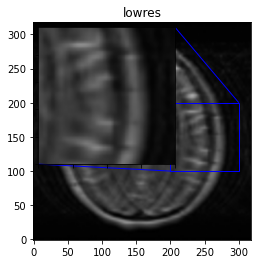

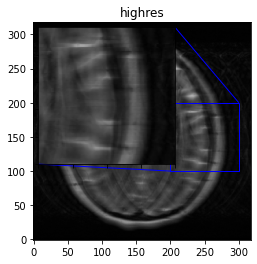

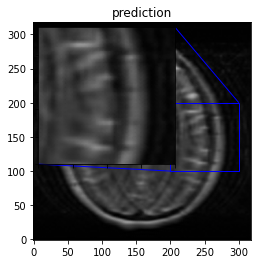

1/1 [==============================] - 0s 20ms/step
PSNR of low resolution image and high resolution image is 36.2287
PSNR of predict and high resolution is 37.2943


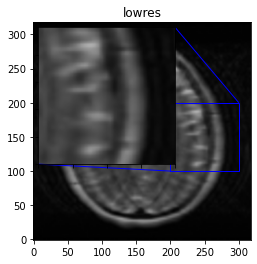

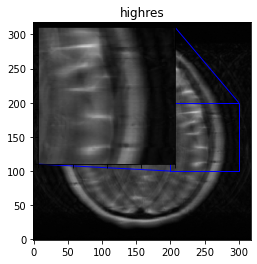

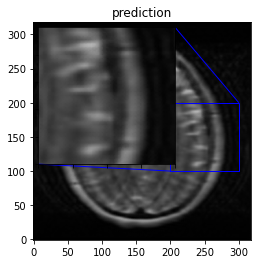

1/1 [==============================] - 0s 22ms/step
PSNR of low resolution image and high resolution image is 37.6859
PSNR of predict and high resolution is 38.3737


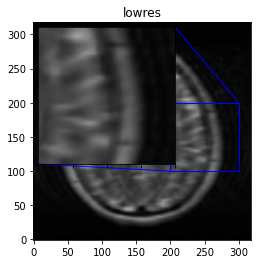

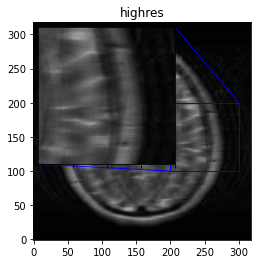

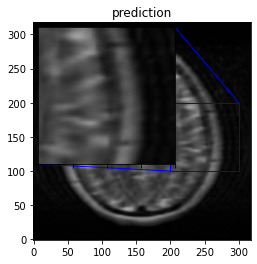

1/1 [==============================] - 0s 19ms/step
PSNR of low resolution image and high resolution image is 37.9099
PSNR of predict and high resolution is 38.1941


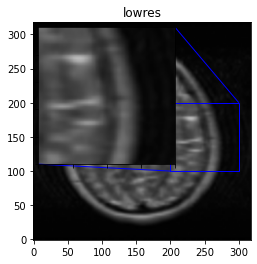

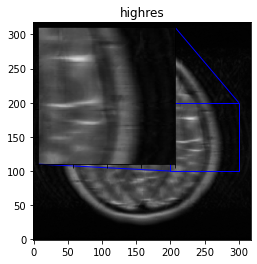

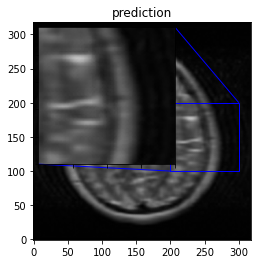

Avg. PSNR of lowres images is 38.9799
Avg. PSNR of reconstructions is 39.2618


In [16]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))